# Projet : Essai de prédiction de l'état de fatigue par Deep Learning

In [2]:
from alphawaves.dataset import AlphaWaves
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mne

C:\Users\alexc\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 1. Premier pas avec la Data Base

In [4]:
# Le dataset
dataset = AlphaWaves()

In [5]:
# Charger les informations sur les sujets (étiquettes)
demoh = pd.read_csv("demographic_header.csv", sep=",", header=None)
headers = demoh.iloc[0].tolist()  # transforme la ligne en liste
demog = pd.read_csv("demographic.csv", sep=",", header=None)
demog.columns = headers
print(demog.head())

   Subject  IsMan  Age  Fatigue
0        1      1   27        5
1        2      1   23        0
2        3      1   44        2
3        4      1   26        2
4        5      1   26        4


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\alexc\AppData\Local\Temp\ipykernel_28360\2291201627.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  brut.compute_psd(fmin=8, fmax=12).plot() # ondes alphas
C:\Users\alexc\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


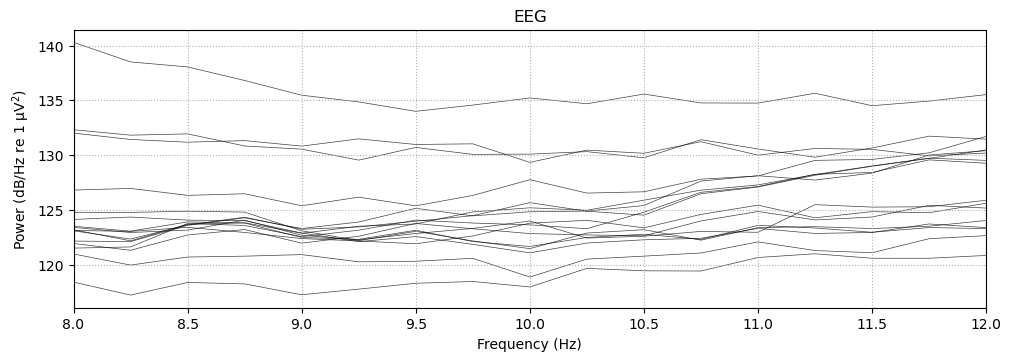

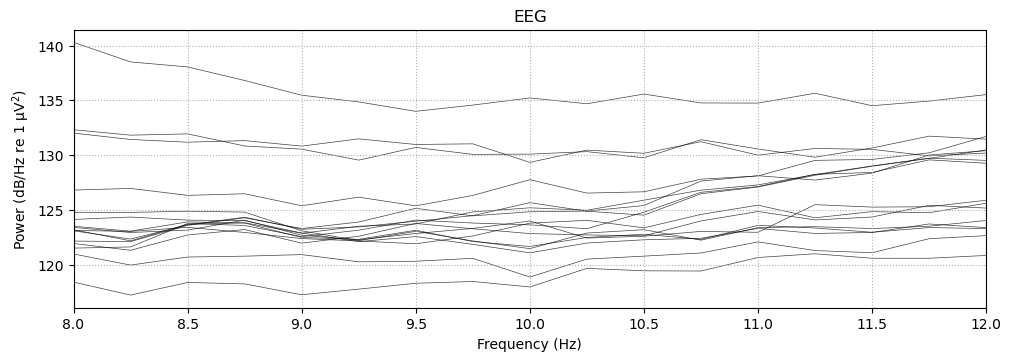

In [6]:
# Visualisation d'un sujet
subject = dataset.subject_list[0]
brut = dataset._get_single_subject_data(subject)
brut.compute_psd(fmin=8, fmax=12).plot() # ondes alphas

In [7]:
# Comme pas de localisation (x,y,z) on prend le montage 10-20 worldwide
montage = mne.channels.make_standard_montage("standard_1020")
brut.set_montage(montage, match_case=False, on_missing="ignore")

<RawArray | 17 x 119808 (234.0 s), ~15.6 MiB, data loaded>

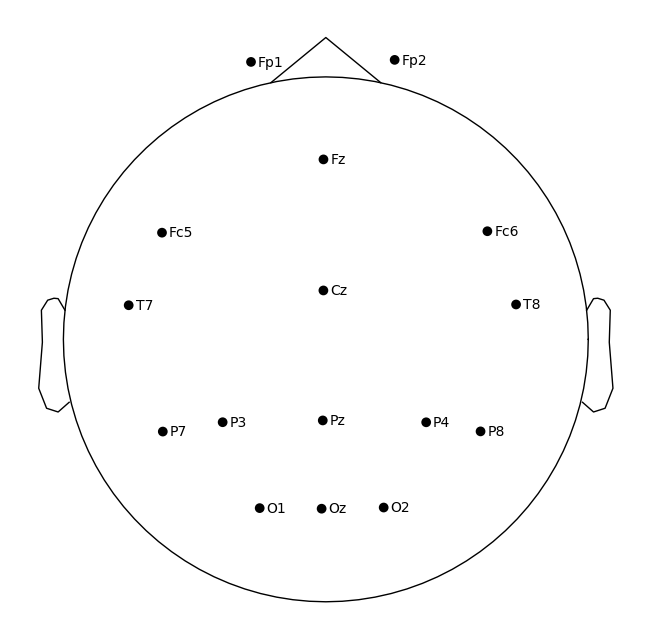

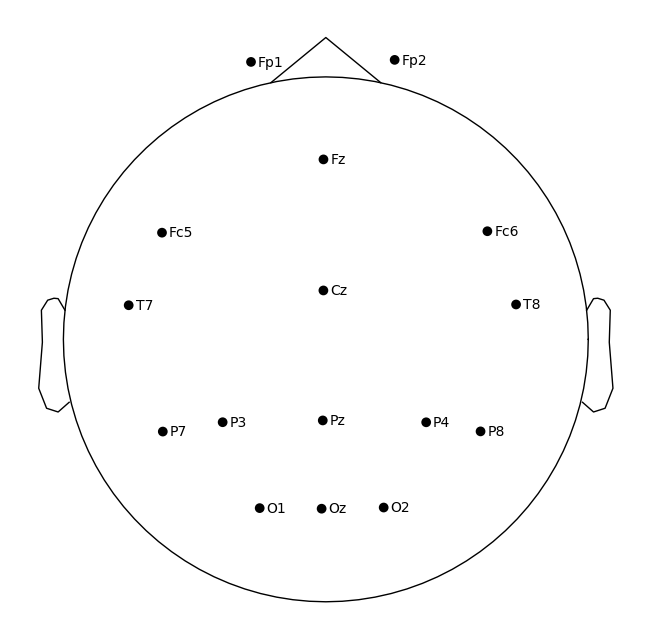

In [8]:
# Affichage des électrodes
brut.plot_sensors(show_names=True)

## 2. Prétraitement des signaux

In [17]:
def pretraite_brut(dataset=dataset, subject:int=0, fmin=5, fmax=40, sfreq=512, tmin=2, tmax=8):
  """Prétraitement du signal (ondes alphas) et fenêtrage (yeux fermés)"""
  # On charge le sujet
  sujet = dataset.subject_list[subject]
  signal = dataset._get_single_subject_data(sujet)
  # Filtrage et rééchantillonage
  signal.filter(fmin,fmax, verbose=True)
  signal.resample(sfreq, verbose=False)
  # Moments Yeux fermés
  events = mne.find_events(signal, shortest_event=1, verbose=True)
  events_id = {"closed":1, "open":2}
  epochs_closed = mne.Epochs(signal, events, event_id={"closed":1}, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose=True, picks='eeg')
  return epochs_closed

In [11]:
def ajoute_montage(raw, montage_name="standard_1020"):
    """Ajoute un montage standard au signal brut EEG pour permettre les topomaps."""
    montage = mne.channels.make_standard_montage(montage_name)
    raw.set_montage(montage, match_case=False, on_missing="ignore")
    return raw

In [19]:
# epochs 'closed' pour le  0
epochs_closed = pretraite_brut(dataset, subject=0)
print(epochs_closed.get_data().shape)  # (n_trials, n_channels, n_times)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (1.650 s)

Finding events on: stim
10 events found on stim channel stim
Event IDs: [1 2]
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 3073 original time points ...
0 bad epochs dropped
(5, 16, 3073)


In [21]:
def epochs_to_Xy(epochs, demog, subject_id:int,
                 normalize=True, win_sec=None, stride_sec=None,
                 keras_time_last=True):
    """Transforme des epochs 'closed' en (X, y) avec le label fatigue du sujet."""
    X = epochs.get_data()  # (n_epochs, n_ch, n_time)
    if X.size == 0:
        return np.empty((0,0,0)), np.empty((0,))

    # z-score par canal (sur toutes les epochs du sujet)
    if normalize:
        mean = X.mean(axis=(0,2), keepdims=True)
        std  = X.std(axis=(0,2), keepdims=True)
        X = (X - mean) / (std + 1e-8)

    # option: re-fenêtrer à l'intérieur des epochs
    if win_sec is not None and stride_sec is not None:
        sf = epochs.info['sfreq']
        win = int(win_sec * sf); hop = int(stride_sec * sf)
        segs = []
        for ep in X:  # (ch, time)
            N = ep.shape[1]
            for s in range(0, max(1, N - win + 1), hop):
                w = ep[:, s:s+win]
                if w.shape[1] == win:
                    segs.append(w)
        if len(segs) == 0:
            return np.empty((0,0,0)), np.empty((0,))
        X = np.stack(segs, axis=0)  # (n_win_total, ch, win)

    # récupérer la fatigue du sujet
    fatigue_col = 'fatigue' if 'fatigue' in demog.columns else 'Fatigue'
    fatigue = float(demog.loc[demog['subject'].astype(int) == int(subject_id), fatigue_col].values[0])
    y = np.full((X.shape[0],), fatigue, dtype=np.float32)

    # format Keras
    if keras_time_last:
        X = np.transpose(X, (0, 2, 1)).astype(np.float32)  # (n, time, ch)

    return X, y

In [23]:
# epochs 'closed' pour le sujet 0
epochs_closed = pretraite_brut(dataset, subject=0, fmin=5, fmax=40, sfreq=128, tmin=2.0, tmax=8.0)

# ID numérique du sujet (1, 2, ...)
sid = dataset.subject_list[0]
sid_int = int(str(sid).split('_')[-1]) if isinstance(sid, str) else int(sid)

# (X, y) prêts pour Keras, sans re-fenêtrage interne
X0, y0 = epochs_to_Xy(epochs_closed, demog, subject_id=sid_int,
                      normalize=True, win_sec=None, stride_sec=None,
                      keras_time_last=True)

print(X0.shape, y0.shape, np.unique(y0))
# Exemple: (n_epochs, n_times, n_channels), (n_epochs,), [fatigue_du_sujet]


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (1.650 s)

Finding events on: stim
10 events found on stim channel stim
Event IDs: [1 2]
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 769 original time points ...
0 bad epochs dropped


KeyError: 'subject'